In [1]:
%load_ext autoreload
%autoreload 2

test_path = "../Datasets/JSRT/Test"

In [2]:
import sys 
sys.path.append('..')

In [3]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

import pathlib
import re

from utils.dataLoader import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

device = 'cuda:0'

In [4]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 6
config['l2'] = 5

double65 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
double65.load_state_dict(torch.load("../weights/Skip/double_L65/best.pt"))
double65.eval()
print('Model loaded')

6-5
Model loaded


In [5]:
hybrid = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid.load_state_dict(torch.load("../weights/HybridGNet/best.pt"))
hybrid.eval()
print('Model loaded')

Model loaded


In [6]:
from models.unet import UNet

unet = UNet(n_classes = 3).to(device)
unet.load_state_dict(torch.load('../weights/UNet/best.pt'))
unet.eval()

print('Model loaded')

Model loaded


In [7]:
import os
from utils.dataLoader import LandmarksDataset, Rescale, ToTensorSegLH

img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensorSegLH()])
                                 )

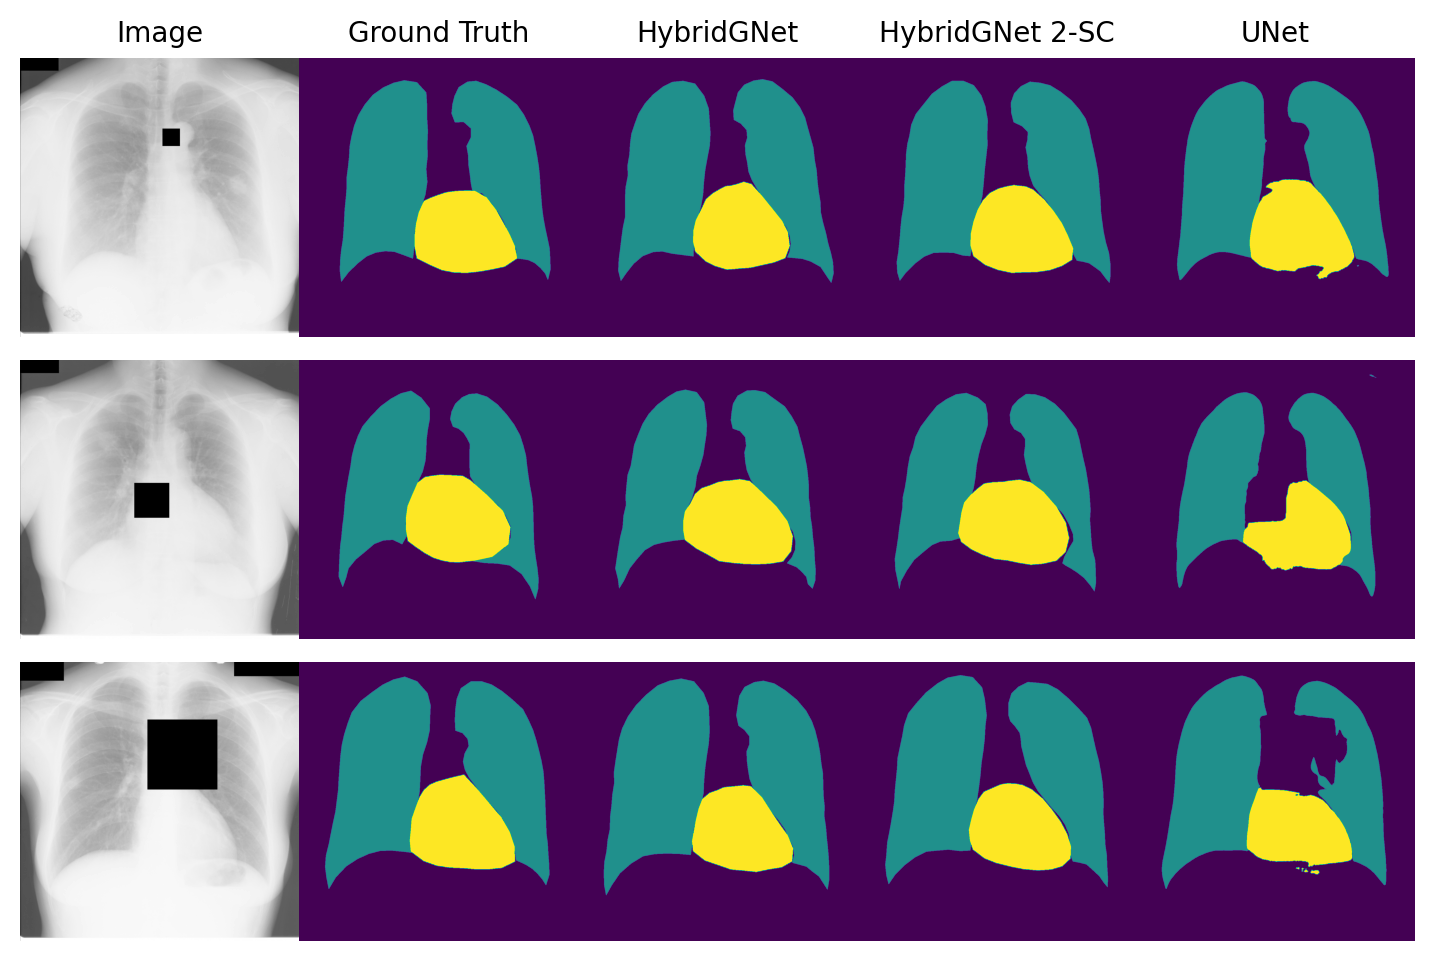

In [8]:
import matplotlib.pyplot as plt
from utils.fun import reverseVector, drawBinary

def genBlock(image, center = (256,256), size = 32):
    a = center[0] - size // 2
    b = center[0] + size // 2
    c = center[1] - size // 2
    d = center[1] + size // 2
    image[0, a:b, c:d] = 0
    
    return image

sample = test_dataset[5]
image, target, seg = sample['image'], sample['landmarks'].to(device), sample['seg']

size = 96

plt.figure(figsize = (9,6), dpi = 200)

for j in range(0, 3):
    sample = test_dataset[j]
    image, target, seg = sample['image'], sample['landmarks'].to(device), sample['seg']

    size = 64 * (2 ** (j))
    
    posx = np.random.randint(256, 1024-256)
    posy = np.random.randint(256, 1024-256)
    
    imageb = image.numpy().copy()
    broken = torch.from_numpy(genBlock(imageb, center = (posx,posy), size = size)).to(device)

    plt.subplot(3,5,1 + j*5)
    plt.imshow(broken[0,:,:].cpu(), cmap = 'gray')
    if j==0:
        plt.title('Image', fontsize=10)
    plt.axis('off')

    plt.subplot(3,5,2 + j*5)
    plt.imshow(seg)
    
    if j==0:
        plt.title('Ground Truth', fontsize=10)
    plt.axis('off')

    with torch.no_grad():
        output = hybrid(torch.unsqueeze(broken,0)).cpu().numpy()
                    
        p1, p2, h, c1, c2 = reverseVector(output.reshape(-1) * 1024)
        
        blank = np.zeros([1024,1024]).astype('uint8')
        lungs = drawBinary(blank.copy(), p1) 
        lungs = drawBinary(lungs, p2) / 255
        heart = drawBinary(blank.copy(), h) / 255
        
        output = lungs + 2 * heart
        output = np.clip(output,0,2)

    plt.subplot(3,5,3 + j*5)
    plt.imshow(output)
    
    if j==0:
        plt.title('HybridGNet', fontsize=10)
    plt.axis('off')
    
    with torch.no_grad():
        output = double65(torch.unsqueeze(broken,0))
        if len(output) > 1:
            output = output[0].cpu().numpy()
                    
        p1, p2, h, c1, c2 = reverseVector(output.reshape(-1) * 1024)
        
        blank = np.zeros([1024,1024]).astype('uint8')
        lungs = drawBinary(blank.copy(), p1) 
        lungs = drawBinary(lungs, p2) / 255
        heart = drawBinary(blank.copy(), h) / 255
        
        output = lungs + 2 * heart
        output = np.clip(output,0,2)

    plt.subplot(3,5,4 + j*5)
    plt.imshow(output)
    
    if j==0:
        plt.title('HybridGNet 2-IGSC', fontsize=10)
    plt.axis('off')

    with torch.no_grad():
        seg_pred = unet(torch.unsqueeze(broken,0))

        seg_pred = seg_pred[0,:,:,:].cpu().numpy().transpose((1,2,0))

        seg_pred = np.argmax(seg_pred, 2)

    plt.subplot(3,5,5 + j*5)
    plt.imshow(seg_pred)
    
    if j==0:
        plt.title('UNet', fontsize=10)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figs/simulated1.png', bbox_inches= 'tight', dpi = 200)
plt.savefig('figs/simulated1.pdf', bbox_inches= 'tight', dpi = 200)
plt.show()

In [9]:
from medpy.metric import dc, hd, assd, jc
from utils.fun import reverseVector, drawBinary

def evalImageMetrics(blank, output, target):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)

    hdp = hd(ptest, target == 1, voxelspacing = 0.35)
    dcp = dc(ptest, target == 1)
    
    ptest = drawBinary(blank.copy(), h)

    hdc = hd(ptest, target == 2, voxelspacing = 0.35)
    dcc = dc(ptest, target == 2)
    
    return (dcp + dcc)/2, (hdp + hdc)/2

def evalImageMetricsUNet(output, target):
    dcp = dc(output == 1, target == 1)
    dcc = dc(output == 2, target == 2)
    
    hdp = hd(output == 1, target == 1, voxelspacing = 0.35)
    hdc = hd(output == 2, target == 2, voxelspacing = 0.35)
    
    return (dcp + dcc)/2, (hdp + hdc)/2

In [10]:
import pandas as pd

results2 = pd.DataFrame()

sizes = [0,  32,  64,  96, 128, 160, 192, 224, 256]
blank = np.zeros([1024,1024]).astype('uint8')

for size in sizes:
    print('Size', size)
    
    for k in range(0, 7):
        posx = np.random.randint(256, 1024-256)
        posy = np.random.randint(256, 1024-256)
                
        for i in range(0, len(test_dataset.images)):
            print('image %s' %i, end='\r', flush = True)
            with torch.no_grad():
                sample = test_dataset[i]

                data, target = sample['image'], sample['seg']

                if size != 0:
                    broken = genBlock(data, center = (posx,posy), size = size)
                    data = torch.unsqueeze(broken, 0).to(device)
                else:
                    data = torch.unsqueeze(data, 0).to(device)

                target = target.numpy()

                with torch.no_grad():
                    output = hybrid(data).cpu().numpy().reshape(-1)
                    dice_, hd_ = evalImageMetrics(blank, output*1024, target)
                    
                    aux = pd.DataFrame([[i, "HybridGNet", size, k, dice_, hd_]], columns=['i', 'Model', 'Oclusion', 'K', 'Dice', 'Hausdorff'])
                    results2 = results2.append(aux, ignore_index = True)
                    
                    output = double65(data)
                    if len(output) > 1:
                        output = output[0].cpu().numpy().reshape(-1)
                    
                    dice_, hd_ = evalImageMetrics(blank, output*1024, target)
                    
                    aux = pd.DataFrame([[i, "HybridGNet 2-IGSC", size, k, dice_, hd_]], columns=['i', 'Model', 'Oclusion', 'K', 'Dice', 'Hausdorff'])
                    results2 = results2.append(aux, ignore_index = True)

                    seg_pred = unet(data)
                    seg_pred = seg_pred[0,:,:,:].cpu().numpy().transpose((1,2,0))
                    seg_pred = np.argmax(seg_pred, 2)                    
                
                    dice_, hd_ = evalImageMetricsUNet(seg_pred, target)
                    
                    aux = pd.DataFrame([[i, "UNet", size, k, dice_, hd_]], columns=['i', 'Model', 'Oclusion', 'K', 'Dice', 'Hausdorff'])
                    results2 = results2.append(aux, ignore_index = True)
                    
        print('')
        if size == 0:
            break

Size 0
image 50
Size 32
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 64
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 96
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 128
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 160
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 192
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 224
image 50
image 50
image 50
image 50
image 50
image 50
image 50
Size 256
image 50
image 50
image 50
image 50
image 50
image 50
image 50


In [11]:
model_names = ["HybridGNet", "HybridGNet 2-IGSC", "UNet"]

dice_plot_means = []
dice_plot_stds = []

for model in model_names:
    model_means = []
    model_stds = []

    for size in sizes:
        means = []
        stds = []
        for k in range(0, 7):
            mean = results2['Dice'][(results2['Model']==model) & (results2['K'] == k) & (results2['Oclusion'] == size)].mean()
            std = results2['Dice'][(results2['Model']==model) & (results2['K'] == k) & (results2['Oclusion'] == size)].std()
            means.append(mean)
            stds.append(std)
            if size == 0:
                break
                
        real_mean = np.mean(means)
        real_std = np.mean(stds)

        model_means.append(real_mean)
        model_stds.append(real_std)
    
    dice_plot_means.append(model_means)
    dice_plot_stds.append(model_stds)
    
hd_plot_means = []
hd_plot_stds = []

for model in model_names:
    model_means = []
    model_stds = []

    for size in sizes:
        means = []
        stds = []
        for k in range(0, 7):
            mean = results2['Hausdorff'][(results2['Model']==model) & (results2['K'] == k) & (results2['Oclusion'] == size)].mean()
            std = results2['Hausdorff'][(results2['Model']==model) & (results2['K'] == k) & (results2['Oclusion'] == size)].std()
            means.append(mean)
            stds.append(std)
            if size == 0:
                break
                
        real_mean = np.mean(means)
        real_std = np.mean(stds)

        model_means.append(real_mean)
        model_stds.append(real_std)
    
    hd_plot_means.append(model_means)
    hd_plot_stds.append(model_stds)

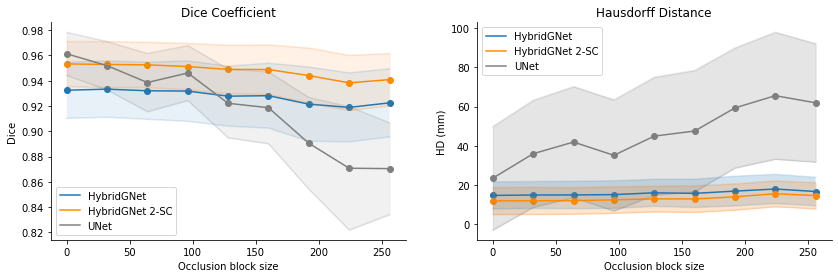

In [12]:
import seaborn as sns

# Define variables to plot
x = np.array(sizes)

pal = sns.color_palette()
pal.as_hex()

blue = list(pal[0]) + [1]
blue = np.array(blue) 

plt.subplots(figsize=(14,4))
ax = plt.subplot(1,2,1)

y_mean = np.array(dice_plot_means[0])
error = np.array(dice_plot_stds[0])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='HybridGNet', color = blue)
ax.scatter(x, y_mean, color = blue)
ax.plot(x, lower, color='tab:blue', alpha=0.15)
ax.plot(x, upper, color='tab:blue', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1)

y_mean = np.array(dice_plot_means[1])
error =np.array(dice_plot_stds[1])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='HybridGNet 2-SC', color = 'darkorange')
ax.scatter(x, y_mean, color = 'darkorange')
ax.plot(x, lower, color='tab:orange', alpha=0.15)
ax.plot(x, upper, color='tab:orange', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1, color='tab:orange')

y_mean = np.array(dice_plot_means[2])
error = np.array(dice_plot_stds[2])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='UNet', color = 'gray')
ax.scatter(x, y_mean, color = 'gray')
ax.plot(x, lower, color='tab:gray', alpha=0.15)
ax.plot(x, upper, color='tab:gray', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.1, color='tab:gray')

ax.set_xlabel('Occlusion block size')
ax.set_ylabel('Dice')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Dice Coefficient')

plt.legend()

ax = plt.subplot(1,2,2)

y_mean = np.array(hd_plot_means[0])
error =np.array(hd_plot_stds[0])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='HybridGNet', color = blue)
ax.scatter(x, y_mean, color = blue)
ax.plot(x, lower, color='tab:blue', alpha=0.15)
ax.plot(x, upper, color='tab:blue', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.2)

y_mean = np.array(hd_plot_means[1])
error =np.array(hd_plot_stds[1])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='HybridGNet 2-SC', color = 'darkorange')
ax.scatter(x, y_mean, color = 'darkorange')
ax.plot(x, lower, color='tab:orange', alpha=0.15)
ax.plot(x, upper, color='tab:orange', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.2, color='tab:orange')

y_mean = np.array(hd_plot_means[2])
error = np.array(hd_plot_stds[2])
lower = y_mean - error
upper = y_mean + error

ax.plot(x, y_mean, label='UNet', color = 'gray')
ax.scatter(x, y_mean, color = 'gray')
ax.plot(x, lower, color='tab:gray', alpha=0.15)
ax.plot(x, upper, color='tab:gray', alpha=0.15)
ax.fill_between(x, lower, upper, alpha=0.2, color='tab:gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Occlusion block size')
ax.set_ylabel('HD (mm)')
ax.set_title('Hausdorff Distance')

plt.legend()
plt.savefig('figs/simulated2.png', bbox_inches='tight', dpi = 300)
plt.savefig('figs/simulated2.pdf', bbox_inches='tight', dpi = 300)
plt.show()